# Advanced Lane Finding Project
## Finding lane boundaries using computer vision techniques


## Camera calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

# Start with camera calibration

# Specify number of corners to find in x and y direction.
nx = 9
ny = 6

# create a matrix for storing the object points
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Create empty list for image and realworld points
img_points = []
obj_points = []

# Name of the folder where calibration files are stored
files = glob.glob('./camera_cal/*.jpg')

print('Loaded camera calibration files...')

for idx,file in enumerate(sorted(files)):
    
    #Start reading the calibration images
    img = plt.imread(file)

    #Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    ret, corners  =cv2.findChessboardCorners(gray,(nx,ny),None)

    if ret:
        obj_points.append(objp)
        img_points.append(corners)
        #Draw the corners
        #cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        #plt.imshow(img)
        #plt.show()
    
print('Loaded {} files'.format(idx) )




Loaded camera calibration files...
Loaded 19 files


In [2]:
# Calibrate the camera
ret, mtx_calibrate,dist_calibrate,rvecs,tvecs = cv2.calibrateCamera(obj_points,img_points,gray.shape[::-1],None,None)

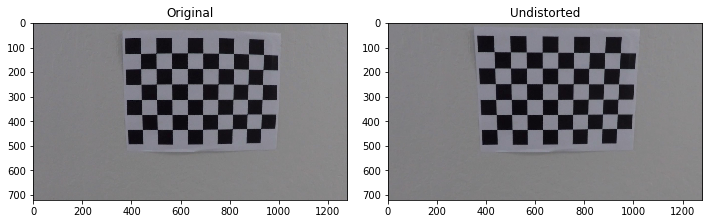

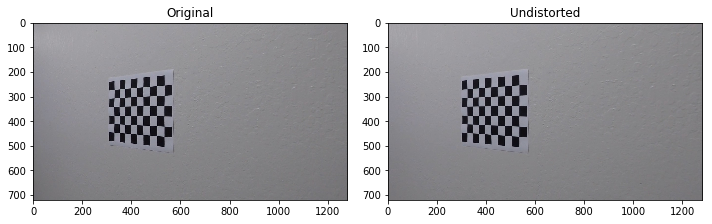

In [3]:
# Display a few of the undistorted images
idx_vector = np.random.choice(len(files),2)

for idx in idx_vector:
    testImage = plt.imread(files[idx])
    dst = cv2.undistort(testImage,mtx_calibrate,dist_calibrate,None,mtx_calibrate)

    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(testImage), ax1.set_title('Original')
    ax2.imshow(dst), ax2.set_title('Undistorted')

    plt.tight_layout()
    plt.show()


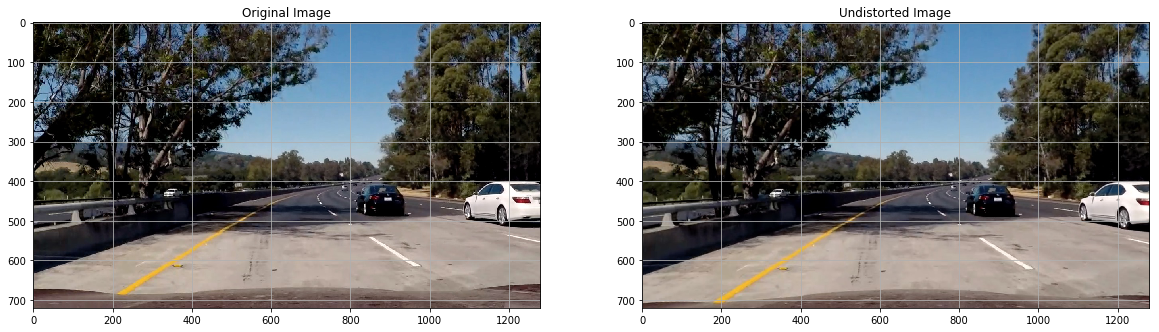

In [4]:
# Applying distortion correction to one of the vehicle test images

# Use one of the saved examples to test the pipeline
test_file = './test_images/test5.jpg' 
test_image = plt.imread(test_file)

# test_file = './test_images/hard_video_first_frame.jpg' 
# test_image = np.uint8(plt.imread(test_file))

# Apply distortion correction
dst = cv2.undistort(test_image,mtx_calibrate,dist_calibrate,None,mtx_calibrate)

#Plot original and undistorted image side by side
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(test_image), ax1.set_title('Original Image'), ax1.grid('on')
ax2.imshow(dst), ax2.set_title('Undistorted Image'), ax2.grid('on')
plt.show()


## Image Thresholding
Experiment with different types of thresholding techniques.

### Color Thresholding with H and S channels in HSL color space

In [5]:
def color_threshold_hls(img,s_thresh=(50,255),h_thresh=(20,70)):
    
    # convert to hls
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Applying clahe to get better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    s_channel = clahe.apply(s_channel.astype(np.uint8))
    l_channel = clahe.apply(l_channel.astype(np.uint8))

    
    s_channel_binary= np.zeros_like(s_channel)
    s_channel_binary[(s_thresh[0]<=s_channel)&(s_channel<=s_thresh[1])] = 1

    h_channel_binary = np.zeros_like(h_channel)
    h_channel_binary[(h_thresh[0]<=h_channel)&(h_channel<=h_thresh[1])]=1
    
    return h_channel, s_channel, l_channel, h_channel_binary, s_channel_binary


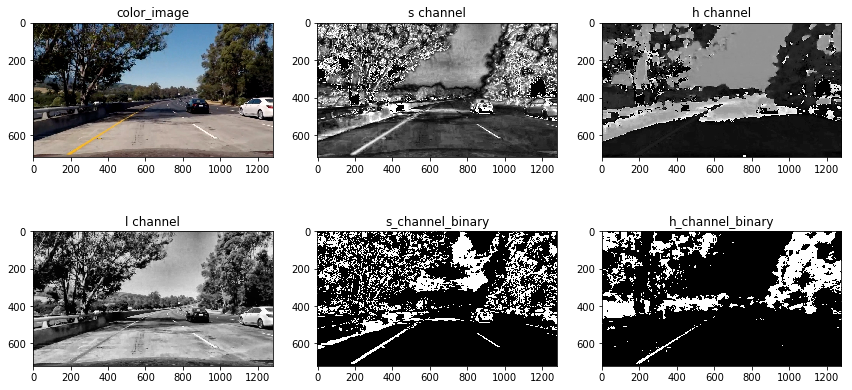

In [6]:
# Color thresholding with h and s channel in hsl colorspace
s_thresh=(150,255)
h_thresh=(20,70)

# Use the undistorted image from the previous step 
img = np.copy(dst)

h_channel, s_channel, l_channel, h_channel_binary, s_channel_binary = color_threshold_hls(img,s_thresh,h_thresh)
                 
# plot side by side:
fig, (ax1,ax2) = plt.subplots(2,3, figsize = (12,6))

ax1[0].imshow(img), ax1[0].set_title('color_image')
ax1[1].imshow(s_channel,cmap='gray'), ax1[1].set_title('s channel')
ax1[2].imshow(h_channel,cmap='gray'), ax1[2].set_title('h channel')
ax2[0].imshow(l_channel,cmap='gray'), ax2[0].set_title('l channel')
ax2[1].imshow(s_channel_binary,cmap='gray'), ax2[1].set_title('s_channel_binary')
ax2[2].imshow(h_channel_binary,cmap='gray'), ax2[2].set_title('h_channel_binary')

plt.tight_layout()
plt.show()

### Gradient Thresholding on L channel of HSL colorspace:


In [7]:
#%% Gradient thresholding on l channel
def gradient_thresholding(gray,grad_dir='x',sobel_thresh = (20,100)):
    if grad_dir=='x':
        sobel = np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if grad_dir=='y':
        sobel = np.abs(cv2.Sobel(gray,cv2.CV_64F,0,1))
        
    #scale and convert to grayscale
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))

    #thresholding
    sb_binary = np.zeros_like(scaled_sobel)
    sb_binary[(sobel_thresh[0]<=scaled_sobel)&(scaled_sobel<=sobel_thresh[1])]=1

    return scaled_sobel, sb_binary 


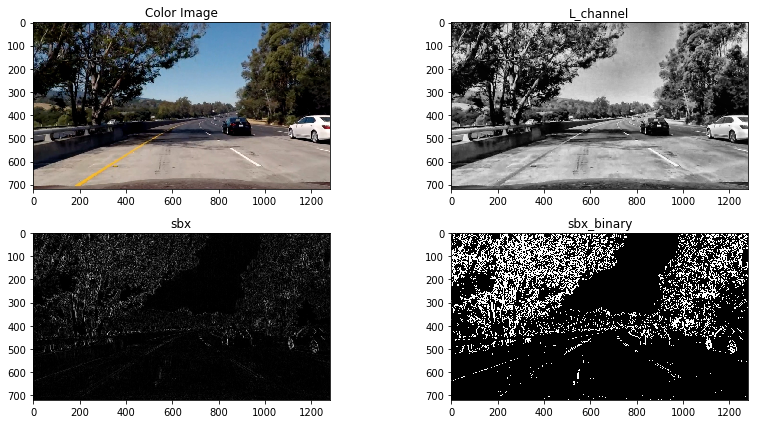

In [8]:
sx_thresh = (20,255)

scaled_sobel_x, sbx_binary = gradient_thresholding(l_channel,'x',sx_thresh)

fig2, (ax1,ax2) = plt.subplots(2,2, figsize = (12,6))

ax1[0].imshow(img), ax1[0].set_title('Color Image')
ax1[1].imshow(l_channel,cmap='gray'), ax1[1].set_title('L_channel')
ax2[0].imshow(scaled_sobel_x,cmap='gray'), ax2[0].set_title('sbx')
ax2[1].imshow(sbx_binary,cmap='gray'), ax2[1].set_title('sbx_binary')

plt.tight_layout()
plt.show()

### Combine all binaries into a single binary

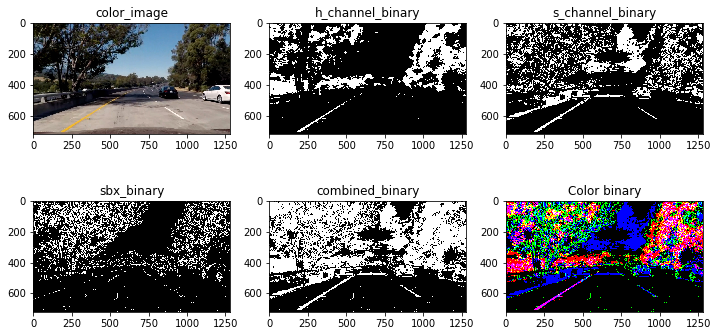

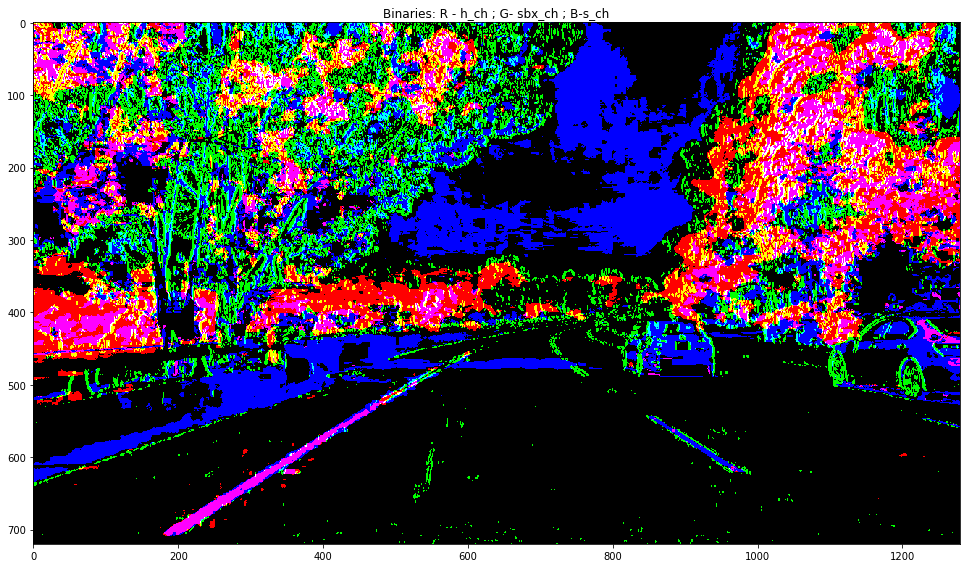

In [9]:
# Combined image
color_binary = np.dstack((h_channel_binary, sbx_binary, s_channel_binary))

combined_binary = np.zeros_like(s_channel)
combined_binary[(h_channel_binary==1)|(s_channel_binary==1)|(sbx_binary==1)]=1
                
fig3, (ax1,ax2) = plt.subplots(2,3, figsize = (12,6))
ax1[0].imshow(img), ax1[0].set_title('color_image')
ax1[1].imshow(h_channel_binary,cmap='gray'), ax1[1].set_title('h_channel_binary')
ax1[2].imshow(s_channel_binary,cmap='gray'), ax1[2].set_title('s_channel_binary')
ax2[0].imshow(sbx_binary,cmap='gray'), ax2[0].set_title('sbx_binary')
ax2[1].imshow(combined_binary,cmap='gray'), ax2[1].set_title('combined_binary')
ax2[2].imshow(color_binary), ax2[2].set_title('Color binary')

#%% Plot the color binary separately
fig4 = plt.figure(4,figsize=(16,8))
plt.imshow(color_binary), plt.title('Binaries: R - h_ch ; G- sbx_ch ; B-s_ch')
plt.tight_layout()
plt.show()

### Create master image thresholding function.
These results looks reasonable. Let's create a new function which includes all the thresholding functions. This function will be used in the video pipeline.


In [10]:
def apply_all_thresholding(img,s_thresh,h_thresh,sx_thresh):
    
    h_channel, s_channel, l_channel, h_channel_binary, s_channel_binary = color_threshold_hls(img,s_thresh,h_thresh)

    scaled_sobel_x, sbx_binary = gradient_thresholding(l_channel,'x',sx_thresh)

    combined_binary = np.zeros_like(s_channel)

    combined_binary[(h_channel_binary==1)|(s_channel_binary==1)|(sbx_binary==1)]=1

    return combined_binary
    
    

## Applying perspective transform to get the bird's eye view

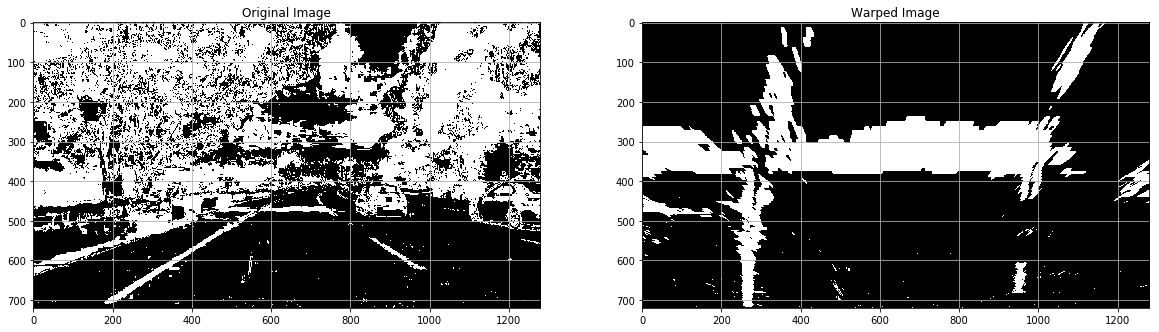

In [11]:
src = np.float32([[600,450],[700,450],[1200,720],[200,720]])  # orig
dst = np.float32([[640-350,0],[640+350,0],[640+350,720],[640-350,720]]) # topview       
M_perspective = cv2.getPerspectiveTransform(src,dst)

#Get the inverse perspective transform as well;
Minv_perspective = cv2.getPerspectiveTransform(dst,src)


binary_warped = cv2.warpPerspective(combined_binary,M_perspective,(combined_binary.shape[1], combined_binary.shape[0]))


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(combined_binary,cmap='gray'), ax1.set_title('Original Image'), ax1.grid('on')
ax2.imshow(binary_warped,cmap='gray'), ax2.set_title('Warped Image'), ax2.grid('on')
plt.show()



## Sliding window for lane detection

In [12]:
def get_lanes_from_histogram(binary_warped):
    # get lower half of the image and take histogram to find lane start
    histogram =  np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)

    # use the x of max value from left and right hand side as the bottom of l and r lanes.
    midpoint = histogram.shape[0]//2

    leftlane_x = np.argmax(histogram[:midpoint]) 
    rightlane_x = np.argmax(histogram[midpoint:]) + midpoint

    return leftlane_x, rightlane_x, histogram

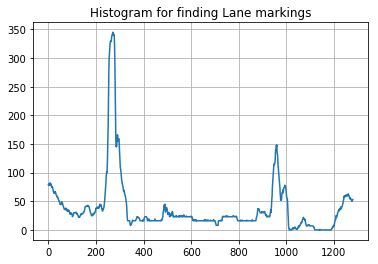

Left lane detected at x  = 271
Right lane detected at x = 958 


In [13]:
#%% Get the histogram representation of the lane markings.
leftlane_x,rightlane_x,histogram  =   get_lanes_from_histogram(binary_warped)

plt.plot(histogram), plt.grid('on')
plt.title('Histogram for finding Lane markings')
plt.show()
print('Left lane detected at x  = {}'.format(leftlane_x)) 
print('Right lane detected at x = {} '.format(rightlane_x))


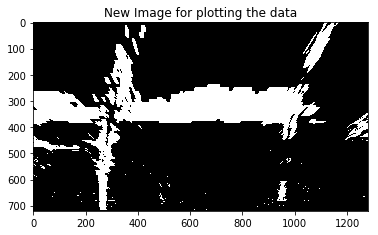

In [14]:
#create a new image for plotting the lines and such
new_image = np.dstack((binary_warped,binary_warped,binary_warped)) * 255
# new_image = np.uint8(new_image)
plt.imshow(new_image)
plt.title('New Image for plotting the data')
plt.show()


In [15]:
# Defining a class to keep track of the left and right lanes
class Line():
    
    # class variable
    num_saved_instances =5

    def __init__(self,name):
        
        # specify name of the instance
        self.name = name
        # was line detected in last iteration
        self.detected = False
        
        #continuous non detection count
        self.not_detected_count = 0
        
        #x values for detected line pixels
        self.currentx = None
        # y values for detected line pixels
        self.currenty = None
        # poly fit for last iteration
        self.current_fit = [np.array([False])]

        # x values of last n fits
        self.recent_x_fitted = np.array([])
        # average val of x values of last n fits
        self.bestx = None

        # poly coeff over last n iterations
        self.recent_fits = np.array([])
        # average val of polyfit coeff over last n iterations
        self.bestfit = np.array([0,0,0],dtype = float)

        # diff in coeff values for last and current fit
        self.diffs = np.array([0,0,0],dtype = float)

        # Rad of curvature of line in meters
        self.radius_of_curvature_meters = None
        #Distance in meters of vehicle center from line
        self.line_base_pos = None
        
    def calculate_radius_curve(self,y_in_px, xm_per_px,ym_per_px,ploty):
        '''
        will be dx/dy instead of dy/dx, since we are using f(y)
                          ​ (1+ (dx/dy)^2 ) ^(3/2)
        R​curve​​ =        ------------------
                              d2x/dy2

        For the 2nd order polynomial: Ay^2 + By + c
                    (1+ (2Ay+B)^2)^(3/2)
        Rcurve =  -------------------------
                          |2A|  
        '''
        # Convert image coordinates to real world coordinates
        y_pos_real = y_in_px*ym_per_px
        ploty_real = ym_per_px* ploty

        x_real  = self.bestx *xm_per_px
        y_real  = ploty_real


        # Get the plotfit. This willbe f(y) and not a f(x), because y vs x is not monotonically increasing. 
        # but x vs y is monotonic.
        my_fit_real  = np.polyfit(y_real,x_real,2)

        # Get the fitx_real values.
        A = my_fit_real[0]
        B = my_fit_real[1]
        C = my_fit_real[2]
        
        # Don't forget to use eps to prevent divide by zero.
        radius = ( (1+ (2*A*y_pos_real+B)**2)**1.5 )/ (np.abs(2*A) + np.finfo(float).eps)
        
        # threshold radius of curvature to 2 km max. Can be larger, using this as initial guess.
        radius  = np.minimum(2000,radius)
        
        self.radius_of_curvature_meters = radius

        return radius

    def update_fitted_values(self,fitx,fity):
        # 1)  Update the current x and y.
        # 2)  Save a rolling buffer of the last "num_saved_instances" recorded values. 
        
        self.currentx = fitx
        self.currenty = fity
        
        if (self.recent_x_fitted.shape[0])==0  :
            self.recent_x_fitted = np.array(fitx)
            self.bestx = np.array(fitx)
            
        else:
            self.recent_x_fitted = np.column_stack((self.recent_x_fitted,fitx))
            if (self.recent_x_fitted.shape[1]>self.num_saved_instances) :
                self.recent_x_fitted= self.recent_x_fitted[:,1:self.num_saved_instances]

            # Using average of last n values.
            # Tried average for 10 values, but that makes the response too slow.    
            self.bestx = np.mean(self.recent_x_fitted,axis=1)
        
        # based on the bestx value, update the bestfit coefficients
        self.bestfit = np.polyfit(self.currenty,self.bestx,2) 

#         # Use low pass filtering
#         temp = np.polyfit(self.currenty,self.bestx,2)
#         self.bestfit = 0.05*temp+ 0.95* self.bestfit 
        # update lane detected variable
        self.detected = True
                

In [16]:
# Create instances of the Line class to keep track of the lanes
left_lane = Line('Left')
right_lane = Line('Right')

# Specify some of the variables needed for the sliding window approach.
win_margin = 100
minpix = 50
n_windows=9


In [17]:
#%% Function to get array of non zero x,y data from the sliding windows
def get_lane_arrays_with_sliding_windows(new_image,binary_warped,leftlane_x,rightlane_x,n_windows=9,win_margin = 100,minpix = 50):
    
    win_height = np.int(binary_warped.shape[0]/n_windows)

    # get x,y vals for all nonzero pixels.
    nonzeros = np.nonzero(binary_warped)
    nonzero_x = np.array(nonzeros[1])
    nonzero_y = np.array(nonzeros[0])


    # Specify current value for the base of lanes
    left_current_x = leftlane_x
    right_current_x = rightlane_x

    # create empty array to keep track of the good pixels
    left_array = []
    right_array = []

    for window in range(n_windows):

        win_y_low =  binary_warped.shape[0] - (window+1) * win_height
        win_y_high =  binary_warped.shape[0] - (window) * win_height

        win_x_left_low  = left_current_x - win_margin
        win_x_left_high = left_current_x + win_margin

        win_x_right_low  = right_current_x - win_margin
        win_x_right_high = right_current_x + win_margin

        # plot the windows
        cv2.rectangle(new_image,(win_x_left_low,win_y_low),(win_x_left_high,win_y_high),(0,255,0),2)

        cv2.rectangle(new_image,(win_x_right_low,win_y_low),(win_x_right_high,win_y_high),(0,255,0),2)

        # Get all the nonzero points in the current window
        win_nonzero_left = ( (win_x_left_low<=nonzero_x) & (nonzero_x< win_x_left_high)
                            & (win_y_low<= nonzero_y) & (nonzero_y< win_y_high) ).nonzero()[0]


        win_nonzero_right = ( (win_x_right_low<=nonzero_x) & (nonzero_x< win_x_right_high)
                            & (win_y_low<= nonzero_y) & (nonzero_y< win_y_high) ).nonzero()[0]

        # Add these inwindow pixels to the array so that we can use them for polyfit
        left_array.append(win_nonzero_left)
        right_array.append(win_nonzero_right)

        # If more than minpix found, 
        # get mean of all the left and right values. update the left&right _current_x for next window.
        if len(win_nonzero_left)> minpix:
            left_current_x = np.int(np.mean(nonzero_x[win_nonzero_left]))

        if len(win_nonzero_right)> minpix:
            right_current_x = np.int(np.mean(nonzero_x[win_nonzero_right]))
    
    left_array = np.concatenate(left_array)        
    right_array = np.concatenate(right_array)        

    leftx = nonzero_x[left_array]
    lefty = nonzero_y[left_array]
    rightx = nonzero_x[right_array]
    righty = nonzero_y[right_array]


    return new_image,leftx,lefty,rightx,righty 

In [18]:
# Test if the sliding mode works as expected.
new_image,leftx,lefty,rightx,righty = get_lane_arrays_with_sliding_windows(new_image,binary_warped,leftlane_x,rightlane_x,n_windows,win_margin,minpix)

#%% Display left and right pixels.
new_image[lefty,leftx] = (255,0,0)
new_image[righty,rightx] = (0,0,255)

# plt.imshow(new_image)
plt.show()

In [19]:
#TODO: The rectangles are in correct places. But they aren't fully drawn. Not sure why!

In [20]:
# Function to get x,y arrays when using previous fit to estimate new lane position 
def get_lane_arrays_with_margins(binary_warped,left_fit,right_fit,win_margin = 100):
    
    # Use this function when we have an estimate of the lanes from previous video frames.
    
    # get x,y values for all non zero pixels
    nonzeros  = np.nonzero(binary_warped)
    nonzero_x = np.array(nonzeros[1])
    nonzero_y = np.array(nonzeros[0])
        
    # Now search for all the non zero pixels within +/- win_margin of  these points
    left_array = ( (nonzero_x> (left_fit[0] * nonzero_y**2 + left_fit[1] * nonzero_y + left_fit[2] - win_margin) ) &  
                   (nonzero_x< (left_fit[0] * nonzero_y**2 + left_fit[1] * nonzero_y + left_fit[2] + win_margin) ) ) 

    # Now search for all the non zero pixels within +/- win_margin of  these points
    right_array = ( (nonzero_x> (right_fit[0] * nonzero_y**2 + right_fit[1] * nonzero_y + right_fit[2] - win_margin) ) &  
                    (nonzero_x< (right_fit[0] * nonzero_y**2 + right_fit[1] * nonzero_y + right_fit[2] + win_margin) ) ) 
    
    leftx  = nonzero_x[left_array]
    lefty  = nonzero_y[left_array]
    rightx = nonzero_x[right_array]
    righty = nonzero_y[right_array]


    return leftx,lefty,rightx,righty 
    

### Get polynomial fit for the lanes

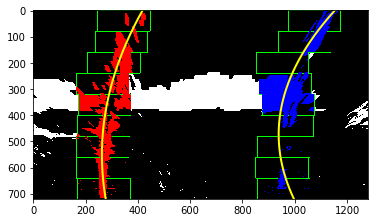

In [21]:
# Get the plotfit. this willbe f(y) and not a f(x)
left_fit  = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)


# Generate x and y values for plotting
ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0])

left_fitx = left_fit[0]* ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]* ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(new_image)

plt.plot(left_fitx,ploty,color='yellow',linewidth=2)
plt.plot(right_fitx,ploty,color='yellow',linewidth=2)
plt.show()
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Save the values for respective lane instance
left_lane.update_fitted_values(left_fitx,ploty)
right_lane.update_fitted_values(right_fitx,ploty)


### Real world coordinate system calcuations 

In [22]:
# Define image to real world conversion factors.

ym_per_px = 30/720 # meters per pixel in y dimension
xm_per_px = 3.7/700 # meters per pixel in x dimension


In [23]:
# Calculate new radius based on the average values from the classes

R_left_real  = left_lane.calculate_radius_curve(binary_warped.shape[0],xm_per_px,ym_per_px,ploty)
R_right_real = right_lane.calculate_radius_curve(binary_warped.shape[0],xm_per_px,ym_per_px,ploty)

print('R_left_real  = {} meter '.format(R_left_real))
print('R_right_real = {} meter'.format(R_right_real))



R_left_real  = 322.86942936250375 meter 
R_right_real = 172.6004639908676 meter


### Calculate the center offset

In [24]:
def calculate_center_offset_m(binary_warped,left_lane,right_lane,xm_per_px):
    bin_y = binary_warped.shape[0]
    (A,B,C) = left_lane.bestfit
    (D,E,F) = right_lane.bestfit
    
    left_y_pos  = A * bin_y**2 +B * bin_y + C
    right_y_pos = D * bin_y**2 +E * bin_y + F
    
    lane_center = (left_y_pos + right_y_pos)/2
    # Assuming that the camera center is the image center,
    offset = binary_warped.shape[1]/2 - lane_center
    
    return offset*xm_per_px


In [25]:
center_offset = calculate_center_offset_m(binary_warped,left_lane,right_lane,xm_per_px)

print('center offset = {0:0.2f} m'.format(center_offset) )

center offset = 0.02 m


### Augment image with polygons and text 

In [26]:
#%% Create a birdeye image with 3 channels to draw the lines on
def draw_polygons(img,binary_warped,left_lane,right_lane,xm_per_px, ploty,win_margin):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#     plt.plot(left_fitx,ploty,color='black',linewidth=2)
#     plt.plot(right_fitx,ploty,color='black',linewidth=2)


    # Generate a polygon to illustrate the lane search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_lane.bestx-win_margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane.bestx+win_margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_lane.bestx-win_margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx+win_margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([left_line_pts]), (255,0, 255))
    cv2.fillPoly(color_warp, np.int_([right_line_pts]), (255,0, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp,Minv_perspective,(binary_warped.shape[1], binary_warped.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return color_warp, result


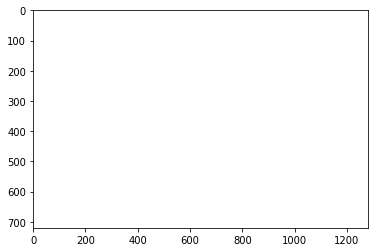

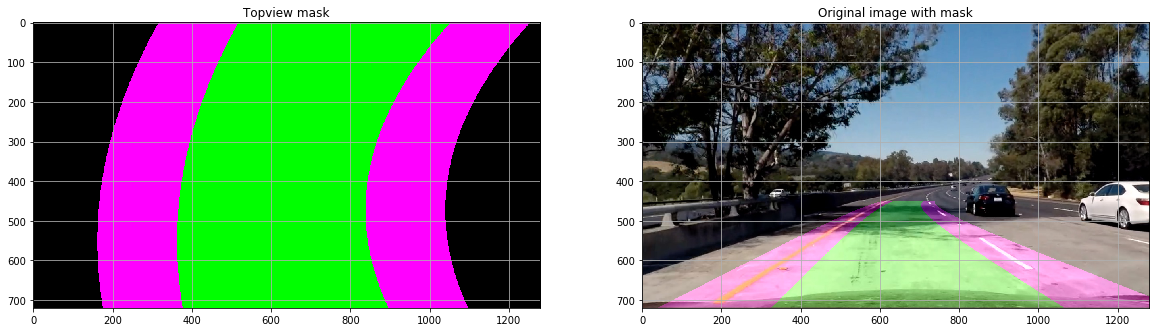

In [27]:
color_warp,result = draw_polygons(img,binary_warped,left_lane,right_lane,xm_per_px, ploty,win_margin)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(color_warp), ax1.set_title('Topview mask'), ax1.grid('on')
ax2.imshow(result), ax2.set_title('Original image with mask'), ax2.grid('on')
plt.show()



In [28]:
#%% Display the radius on the image
def draw_text(image, left_lane,right_lane, center_offset,xmax=1200,ymax=300,size=1,color=(255,255,255),thickness=2):

    # Print the radius of curvature and center offset
    x,y =50,100
    font = cv2.FONT_HERSHEY_SIMPLEX
        
    str_to_display = 'R_left= {0:0.2f} m '.format(left_lane.radius_of_curvature_meters)
    cv2.putText(image,str_to_display,(int(x),int(y)), font, size,color,thickness)
        
    str_to_display = 'R_right= {0:0.2f} m '.format(right_lane.radius_of_curvature_meters)
    cv2.putText(image,str_to_display,(int(x+800),int(y)), font, size,color,thickness)

    str_to_display = 'Center offset = {0:0.2f} m '.format(center_offset)
    cv2.putText(image,str_to_display,(int(x+450),int(50)), font, size,color,thickness)

    return image

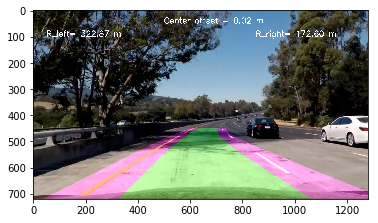

In [29]:
center_offset = calculate_center_offset_m(binary_warped,left_lane,right_lane,xm_per_px)

result = draw_text(result,left_lane,right_lane,center_offset)

#Display the image
plt.imshow(result)
plt.show()


## Run pipeline on video

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [31]:
# Create instances of the Line class to keep track of the lanes
left_lane = Line('Left')
right_lane = Line('Right')


In [32]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)

    #1) Apply distortion correction: 
    img = cv2.undistort(image,mtx_calibrate,dist_calibrate,None,mtx_calibrate)
    
    #2) Apply the image thresholdings that were discussed earlier
    combined_binary = apply_all_thresholding(img,s_thresh,h_thresh,sx_thresh)
                
    #3) Apply perspective transform to get the birds eye plot of the binary image
    binary_warped = cv2.warpPerspective(combined_binary,M_perspective,(combined_binary.shape[1], combined_binary.shape[0]))

    #4) Create a new image to plot the augmentation polygons:
    new_image = np.dstack((binary_warped,binary_warped,binary_warped)) * 255
    new_image = np.uint8(new_image)

    #5) Create y points for calculating fittedx of the detected lanes
    ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0])
    
    
    #6) Code to run either the sliding window or get_lane_arrays_with_margins
    
    if left_lane.bestfit is None :
        
        # 
        # This is the init sequence. So go through the sliding mode so that we can detect the lanes in first image.
        #
        
        # Get the left/right lane bottom x starting position :
        leftlane_x, rightlane_x,histogram  = get_lanes_from_histogram(binary_warped)
        
        # Apply sliding window to get left/right pixels
        new_image,leftx,lefty,rightx,righty = get_lane_arrays_with_sliding_windows(new_image,binary_warped,leftlane_x,rightlane_x,n_windows,win_margin,minpix)

        # Get the plotfit.This willbe f(y) and not a f(x)
        left_fit  = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
        
        # Don't update diffs for first iteration
        
        # Find corresponding x values - 
        left_fitx = left_fit[0]* ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]* ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Save the values for respective lane instance
        left_lane.update_fitted_values(left_fitx,ploty)
        right_lane.update_fitted_values(right_fitx,ploty)

    else:
                
        
        # Run the sliding windows only if lane wasn't detected in previous run -
        if (left_lane.detected & right_lane.detected):

            # Compare this fit with the current fit
            # Notice that big changes start off at the top, where y=0.
            # Seems like the fit[2] i.e constant parameter should be tested for change
            
            diff_threshold = np.float64(30.0)
            
            if  ( (left_lane.diffs[2]> diff_threshold) | (right_lane.diffs[2]>diff_threshold) ):
                left_lane.not_detected_count += 1 
                right_lane.not_detected_count += 1 

                if (left_lane.not_detected_count>5 or right_lane.not_detected_count>5):
                    left_lane.detected = False
                    right_lane.detected = False

            else:
                # reset the not detected count since we are in this loop. 
                # Not detected count is used/updated when lanes not detected in consecutive images.
                left_lane.not_detected_count  = 0 
                right_lane.not_detected_count = 0 

                leftx,lefty,rightx,righty = get_lane_arrays_with_margins(binary_warped,left_lane.bestfit,right_lane.bestfit)
                # TODO: Not sure if I should use all polyfit coeffs or not.Experiment later.

                # Get the plotfit.This willbe f(y) and not a f(x)
                left_fit  = np.polyfit(lefty,leftx,2)
                right_fit = np.polyfit(righty,rightx,2)

                left_lane.diffs  = np.abs(left_fit-left_lane.bestfit)
                right_lane.diffs = np.abs(right_fit-right_lane.bestfit)

                # Find corresponding x values - 
                left_fitx = left_fit[0]* ploty**2 + left_fit[1]*ploty + left_fit[2]
                right_fitx = right_fit[0]* ploty**2 + right_fit[1]*ploty + right_fit[2]

                # Save the values for respective lane instance
                left_lane.update_fitted_values(left_fitx,ploty)
                right_lane.update_fitted_values(right_fitx,ploty)


        else:
            # We are here because (left_lane.detected & right_lane.detected) wasn't true.
            # This means that we lost track of atleast 1 lane.
            # TODO: Should I be tackling lost lanes separately?
            
            # reset the not detected count, since we are in this loop
            left_lane.not_detected_count  = 0 
            right_lane.not_detected_count = 0 


            # Get the left/right lane bottom x starting position :
            leftlane_x, rightlane_x,histogram  = get_lanes_from_histogram(binary_warped)

            # Apply sliding window to get left/right pixels
            new_image,leftx,lefty,rightx,righty = get_lane_arrays_with_sliding_windows(new_image,binary_warped,leftlane_x,rightlane_x,n_windows,win_margin,minpix)

            # Get the plotfit.This willbe f(y) and not a f(x)
            left_fit  = np.polyfit(lefty,leftx,2)
            right_fit = np.polyfit(righty,rightx,2)

            # Set diffs to 0 
            left_lane.diffs  = np.array([0,0,0],dtype = float)
            right_lane.diffs = np.array([0,0,0],dtype = float)

            # Find corresponding x values - 
            left_fitx = left_fit[0]* ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]* ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Save the values for respective lane instance
            left_lane.update_fitted_values(left_fitx,ploty)
            right_lane.update_fitted_values(right_fitx,ploty)


    #7) Calculate new radius of curvature based on the average values from the classes
    R_left_real  = left_lane.calculate_radius_curve(binary_warped.shape[0],xm_per_px,ym_per_px,ploty)
    R_right_real = right_lane.calculate_radius_curve(binary_warped.shape[0],xm_per_px,ym_per_px,ploty)

    #8) Draw the lane marking polygons on the image
    color_warp,result = draw_polygons(img,binary_warped,left_lane,right_lane,xm_per_px, ploty,win_margin)

    #9) Calculate the center offset:
    center_offset = calculate_center_offset_m(binary_warped,left_lane,right_lane,xm_per_px)
    
    #10) Draw the text on the image
    result = draw_text(result,left_lane,right_lane,center_offset)

    #11) Return the final image
    return result


In [33]:
white_output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [03:11<00:00,  6.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 8min 12s, sys: 3.46 s, total: 8min 15s
Wall time: 3min 12s
